In [1]:
from keras import optimizers
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras import backend as K
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from glob import glob
from PIL import Image
from keras.utils.np_utils import to_categorical
from seaborn import set_context
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
RANDOM_STATE = 2401
np.random.seed(RANDOM_STATE)

%matplotlib inline

Using TensorFlow backend.


In [2]:
base_skin_dir = os.path.join('..', 'input')

# Merge images from both folders into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.png'))}

# This dictionary is useful for displaying more human-friendly labels later on

type_dict = {
    0 : 'Grade 1',
    1 : 'Grade 2',
    2 : 'Grade 3'
}

In [3]:
images = []
ids = []
folders = ["../input/tests"]
for folder in folders:
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.resize(img,(256,256))
        if img is not None:
            images.append(img)
            ids.append(filename)

In [4]:
x_test = np.asarray(images)
x_test = x_test/255.0

In [5]:
df = pd.read_csv('../input/embryogrades.csv')

In [6]:
df['path'] = df['id'].map(imageid_path_dict.get)
df['grade'] = df['kelas'].map(type_dict.get)

In [7]:
df.sample(10)

,id,kelas,path,grade
373,kelas2 (232),1,../input/trains/kelas2 (232).png,Grade 2
423,kelas3 (28),2,../input/trains/kelas3 (28).png,Grade 3
258,kelas2 (119),1,../input/trains/kelas2 (119).png,Grade 2
178,kelas2 (73),1,../input/trains/kelas2 (73).png,Grade 2
433,kelas3 (17),2,../input/trains/kelas3 (17).png,Grade 3
382,kelas2 (203),1,../input/trains/kelas2 (203).png,Grade 2
326,kelas2 (128),1,../input/trains/kelas2 (128).png,Grade 2
380,kelas2 (189),1,../input/trains/kelas2 (189).png,Grade 2
426,kelas3 (20),2,../input/trains/kelas3 (20).png,Grade 3
51,kelas1 (117),0,../input/trains/kelas1 (117).png,Grade 1


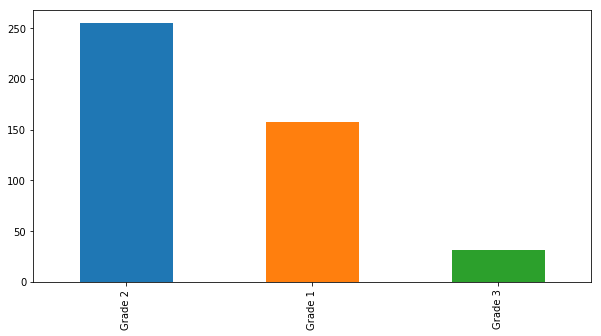

In [8]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df['grade'].value_counts().plot(kind='bar', ax=ax1)

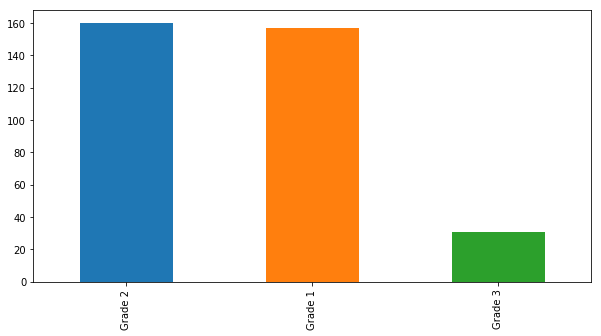

In [9]:
df = df.drop(df[df.kelas == 1].iloc[:95].index)

fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df['grade'].value_counts().plot(kind='bar', ax=ax1)

In [10]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((256,256),1)))

In [11]:
y = df.kelas

**Start Model**

In [12]:
from sklearn.model_selection import train_test_split
x_train_o, x_val_o, y_train_o, y_val_o = train_test_split(df, y, test_size=0.25)
print(x_train_o.shape)

x_train = np.asarray(x_train_o['image'].tolist())
x_val = np.asarray(x_val_o['image'].tolist())
print(x_train.shape)

# x_train_mean = np.mean(x_train)
# x_train_std = np.std(x_train)

# x_val_mean = np.mean(x_val)
# x_val_std = np.std(x_val)
# print(x_val_mean)
# print(x_val_std)

# X_train = (x_train - x_train_mean)/x_train_std
# X_val = (x_val - x_val_mean)/x_val_std
# print(x_train.shape)

# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 3)
y_val = to_categorical(y_val_o, num_classes = 3)

(261, 5)
(261, 256, 256, 4)


In [13]:
x_train = np.delete(x_train, 3,3)
x_val = np.delete(x_val, 3,3)

In [14]:
x_train = x_train/255
x_val = x_val/255

In [15]:
from keras.applications.xception import Xception
application = Xception(include_top=False, weights='imagenet',input_shape=(256, 256, 3))

83689472/83683744 [==============================] - 1s 0us/step


In [16]:
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(application)
 
# Add new layers
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 8, 8, 2048)        20861480  
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 6, 6, 64)          1179712   
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
__________

In [17]:
batch_size = 16
num_classes = 3
epochs = 500

In [18]:
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.00001),metrics=['acc'])
early_stopping = EarlyStopping(monitor='val_acc', min_delta=0,patience=300, verbose=1, mode='max',
                               baseline=None, restore_best_weights=True)
# Train the model
hist = model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_val, y_val),
                 validation_split=0.8,callbacks=[early_stopping])


Train on 261 samples, validate on 87 samples
Epoch 1/500
261/261 [==============================] - 19s 73ms/step - loss: 1.0522 - acc: 0.4330 - val_loss: 0.9989 - val_acc: 0.5172
Epoch 2/500
261/261 [==============================] - 5s 20ms/step - loss: 0.8992 - acc: 0.5900 - val_loss: 0.9735 - val_acc: 0.5057
Epoch 3/500
261/261 [==============================] - 5s 20ms/step - loss: 0.8183 - acc: 0.6552 - val_loss: 0.9581 - val_acc: 0.5747
Epoch 4/500
261/261 [==============================] - 5s 20ms/step - loss: 0.7408 - acc: 0.6935 - val_loss: 0.9582 - val_acc: 0.5402
Epoch 5/500
261/261 [==============================] - 5s 20ms/step - loss: 0.6255 - acc: 0.7931 - val_loss: 0.9505 - val_acc: 0.5517
Epoch 6/500
261/261 [==============================] - 5s 20ms/step - loss: 0.5702 - acc: 0.7969 - val_loss: 0.9534 - val_acc: 0.5862
Epoch 7/500
261/261 [==============================] - 5s 20ms/step - loss: 0.4788 - acc: 0.8621 - val_loss: 0.9654 - val_acc: 0.5747
Epoch 8/500
261/

261/261 [==============================] - 5s 20ms/step - loss: 0.0322 - acc: 0.9923 - val_loss: 1.7116 - val_acc: 0.5632
Epoch 122/500
261/261 [==============================] - 5s 20ms/step - loss: 0.0115 - acc: 0.9962 - val_loss: 2.2272 - val_acc: 0.5057
Epoch 123/500
261/261 [==============================] - 5s 20ms/step - loss: 0.0438 - acc: 0.9885 - val_loss: 1.5589 - val_acc: 0.5747
Epoch 124/500
261/261 [==============================] - 5s 20ms/step - loss: 0.0308 - acc: 0.9885 - val_loss: 1.9032 - val_acc: 0.6207
Epoch 125/500
261/261 [==============================] - 5s 20ms/step - loss: 0.0097 - acc: 1.0000 - val_loss: 1.6905 - val_acc: 0.5977
Epoch 126/500
261/261 [==============================] - 5s 20ms/step - loss: 0.0085 - acc: 0.9962 - val_loss: 1.6767 - val_acc: 0.5977
Epoch 127/500
261/261 [==============================] - 5s 20ms/step - loss: 0.0107 - acc: 0.9962 - val_loss: 1.7029 - val_acc: 0.5977
Epoch 128/500
261/261 [==============================] - 5s 20

261/261 [==============================] - 5s 20ms/step - loss: 0.0100 - acc: 0.9962 - val_loss: 2.0789 - val_acc: 0.6092
Epoch 242/500
261/261 [==============================] - 5s 20ms/step - loss: 0.0060 - acc: 1.0000 - val_loss: 1.9207 - val_acc: 0.5632
Epoch 243/500
261/261 [==============================] - 5s 20ms/step - loss: 0.0065 - acc: 0.9962 - val_loss: 1.9283 - val_acc: 0.5747
Epoch 244/500
261/261 [==============================] - 5s 20ms/step - loss: 0.0072 - acc: 0.9962 - val_loss: 1.9297 - val_acc: 0.5747
Epoch 245/500
261/261 [==============================] - 5s 20ms/step - loss: 0.0050 - acc: 0.9962 - val_loss: 1.9457 - val_acc: 0.5747
Epoch 246/500
261/261 [==============================] - 5s 20ms/step - loss: 0.0103 - acc: 0.9923 - val_loss: 1.9638 - val_acc: 0.5862
Epoch 247/500
261/261 [==============================] - 5s 20ms/step - loss: 0.0067 - acc: 0.9962 - val_loss: 1.9750 - val_acc: 0.5862
Epoch 248/500
261/261 [==============================] - 5s 20

In [19]:
from keras.applications.resnet50 import ResNet50
application = ResNet50(include_top=False, weights='imagenet',input_shape=(256, 256, 3))

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


In [20]:
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model2 = models.Sequential()
 
# Add the vgg convolutional base model
model2.add(application)
 
# Add new layers
model2.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(3, 3)))
model2.add(Flatten())
model2.add(Dropout(0.25))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(3, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 64)          1179712   
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
__________

In [21]:
batch_size = 16
num_classes = 3
epochs = 500

In [22]:
model2.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.00001),metrics=['acc'])
early_stopping = EarlyStopping(monitor='val_acc', min_delta=0,patience=300, verbose=1, mode='max',
                               baseline=None, restore_best_weights=True)
# Train the model
hist2 = model2.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_val, y_val),
                 validation_split=0.8,callbacks=[early_stopping])


Train on 261 samples, validate on 87 samples
Epoch 1/500
261/261 [==============================] - 20s 76ms/step - loss: 1.6222 - acc: 0.4176 - val_loss: 1.0361 - val_acc: 0.4943
Epoch 2/500
261/261 [==============================] - 3s 13ms/step - loss: 0.8279 - acc: 0.6130 - val_loss: 1.0559 - val_acc: 0.4943
Epoch 3/500
261/261 [==============================] - 3s 13ms/step - loss: 0.6794 - acc: 0.7088 - val_loss: 1.0506 - val_acc: 0.4713
Epoch 4/500
261/261 [==============================] - 3s 13ms/step - loss: 0.5687 - acc: 0.7395 - val_loss: 1.0531 - val_acc: 0.4943
Epoch 5/500
261/261 [==============================] - 3s 13ms/step - loss: 0.4613 - acc: 0.8276 - val_loss: 1.0305 - val_acc: 0.5402
Epoch 6/500
261/261 [==============================] - 3s 13ms/step - loss: 0.3467 - acc: 0.8697 - val_loss: 1.0240 - val_acc: 0.5517
Epoch 7/500
261/261 [==============================] - 3s 13ms/step - loss: 0.2946 - acc: 0.8966 - val_loss: 1.0562 - val_acc: 0.5057
Epoch 8/500
261/

261/261 [==============================] - 3s 13ms/step - loss: 0.0081 - acc: 0.9962 - val_loss: 1.4358 - val_acc: 0.5172
Epoch 122/500
261/261 [==============================] - 3s 13ms/step - loss: 0.0088 - acc: 0.9962 - val_loss: 1.3957 - val_acc: 0.5402
Epoch 123/500
261/261 [==============================] - 3s 13ms/step - loss: 0.0107 - acc: 0.9962 - val_loss: 1.3784 - val_acc: 0.5402
Epoch 124/500
261/261 [==============================] - 3s 13ms/step - loss: 0.0125 - acc: 0.9923 - val_loss: 1.3713 - val_acc: 0.5517
Epoch 125/500
261/261 [==============================] - 3s 13ms/step - loss: 0.0141 - acc: 0.9923 - val_loss: 1.3559 - val_acc: 0.5517
Epoch 126/500
261/261 [==============================] - 3s 13ms/step - loss: 0.0064 - acc: 0.9962 - val_loss: 1.3389 - val_acc: 0.5632
Epoch 127/500
261/261 [==============================] - 3s 13ms/step - loss: 0.0087 - acc: 0.9962 - val_loss: 1.3314 - val_acc: 0.5402
Epoch 128/500
261/261 [==============================] - 3s 13

261/261 [==============================] - 3s 13ms/step - loss: 0.0116 - acc: 0.9962 - val_loss: 1.5875 - val_acc: 0.5862
Epoch 242/500
261/261 [==============================] - 3s 13ms/step - loss: 0.0105 - acc: 0.9923 - val_loss: 1.5444 - val_acc: 0.5977
Epoch 243/500
261/261 [==============================] - 3s 13ms/step - loss: 0.0165 - acc: 0.9923 - val_loss: 1.4911 - val_acc: 0.5977
Epoch 244/500
261/261 [==============================] - 3s 13ms/step - loss: 0.0086 - acc: 0.9962 - val_loss: 1.5209 - val_acc: 0.6207
Epoch 245/500
261/261 [==============================] - 3s 13ms/step - loss: 0.0182 - acc: 0.9962 - val_loss: 1.5052 - val_acc: 0.6207
Epoch 246/500
261/261 [==============================] - 3s 13ms/step - loss: 0.0145 - acc: 0.9923 - val_loss: 1.2739 - val_acc: 0.5977
Epoch 247/500
261/261 [==============================] - 3s 13ms/step - loss: 0.0183 - acc: 0.9923 - val_loss: 1.3178 - val_acc: 0.5517
Epoch 248/500
261/261 [==============================] - 3s 13

261/261 [==============================] - 3s 13ms/step - loss: 0.0033 - acc: 0.9962 - val_loss: 1.7591 - val_acc: 0.5862
Epoch 362/500
261/261 [==============================] - 3s 13ms/step - loss: 0.0076 - acc: 0.9962 - val_loss: 1.7412 - val_acc: 0.5862
Epoch 363/500
261/261 [==============================] - 3s 13ms/step - loss: 0.0069 - acc: 0.9923 - val_loss: 1.7153 - val_acc: 0.5862
Epoch 364/500
261/261 [==============================] - 3s 13ms/step - loss: 0.0176 - acc: 0.9923 - val_loss: 1.7056 - val_acc: 0.5747
Epoch 365/500
261/261 [==============================] - 3s 13ms/step - loss: 0.0039 - acc: 1.0000 - val_loss: 1.7000 - val_acc: 0.5862
Epoch 366/500
261/261 [==============================] - 3s 13ms/step - loss: 0.0045 - acc: 0.9962 - val_loss: 1.7106 - val_acc: 0.5747
Epoch 367/500
261/261 [==============================] - 3s 13ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 1.7130 - val_acc: 0.5747
Epoch 368/500
261/261 [==============================] - 3s 13

261/261 [==============================] - 3s 13ms/step - loss: 0.0037 - acc: 1.0000 - val_loss: 1.8476 - val_acc: 0.5977
Epoch 482/500
261/261 [==============================] - 3s 13ms/step - loss: 0.0092 - acc: 0.9923 - val_loss: 1.8545 - val_acc: 0.5977
Epoch 483/500
261/261 [==============================] - 3s 13ms/step - loss: 0.0042 - acc: 1.0000 - val_loss: 1.8606 - val_acc: 0.5977
Epoch 484/500
261/261 [==============================] - 3s 13ms/step - loss: 0.0053 - acc: 0.9962 - val_loss: 1.8596 - val_acc: 0.5862
Epoch 485/500
261/261 [==============================] - 3s 13ms/step - loss: 0.0050 - acc: 0.9962 - val_loss: 1.8470 - val_acc: 0.5862
Epoch 486/500
261/261 [==============================] - 3s 13ms/step - loss: 0.0092 - acc: 0.9923 - val_loss: 1.8316 - val_acc: 0.5977
Epoch 487/500
261/261 [==============================] - 3s 13ms/step - loss: 0.0095 - acc: 0.9962 - val_loss: 1.8372 - val_acc: 0.5977
Epoch 488/500
261/261 [==============================] - 3s 13

In [23]:
from keras.applications.mobilenet import MobileNet
application = MobileNet(include_top=False, weights='imagenet',input_shape=(256, 256, 3))

/opt/conda/lib/python3.6/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


17227776/17225924 [==============================] - 0s 0us/step


In [24]:
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model3 = models.Sequential()
 
# Add the vgg convolutional base model
model3.add(application)
 
# Add new layers
model3.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(3, 3)))
model3.add(Flatten())
model3.add(Dropout(0.25))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(3, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 8, 8, 1024)        3228864   
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 6, 6, 64)          589888    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
__________

In [25]:
batch_size = 16
num_classes = 3
epochs = 500

In [26]:
model3.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.00001),metrics=['acc'])
early_stopping = EarlyStopping(monitor='val_acc', min_delta=0,patience=300, verbose=1, mode='max',
                               baseline=None, restore_best_weights=True)
# Train the model
hist3 = model3.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_val, y_val),
                 validation_split=0.8,callbacks=[early_stopping])


Train on 261 samples, validate on 87 samples
Epoch 1/500
261/261 [==============================] - 13s 50ms/step - loss: 2.7002 - acc: 0.2069 - val_loss: 1.1823 - val_acc: 0.4023
Epoch 2/500
261/261 [==============================] - 2s 9ms/step - loss: 1.4597 - acc: 0.3755 - val_loss: 1.1280 - val_acc: 0.4598
Epoch 3/500
261/261 [==============================] - 2s 9ms/step - loss: 1.1385 - acc: 0.4751 - val_loss: 1.0807 - val_acc: 0.5287
Epoch 4/500
261/261 [==============================] - 2s 9ms/step - loss: 1.0095 - acc: 0.4828 - val_loss: 1.0644 - val_acc: 0.5057
Epoch 5/500
261/261 [==============================] - 2s 9ms/step - loss: 0.9257 - acc: 0.5326 - val_loss: 1.0670 - val_acc: 0.4943
Epoch 6/500
261/261 [==============================] - 2s 9ms/step - loss: 0.8762 - acc: 0.5632 - val_loss: 1.0792 - val_acc: 0.5172
Epoch 7/500
261/261 [==============================] - 2s 9ms/step - loss: 0.8352 - acc: 0.6015 - val_loss: 1.0667 - val_acc: 0.5172
Epoch 8/500
261/261 [=

Epoch 62/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0451 - acc: 0.9885 - val_loss: 1.4404 - val_acc: 0.5402
Epoch 63/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0492 - acc: 0.9847 - val_loss: 1.4431 - val_acc: 0.5402
Epoch 64/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0418 - acc: 0.9962 - val_loss: 1.4409 - val_acc: 0.5632
Epoch 65/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0468 - acc: 0.9923 - val_loss: 1.4716 - val_acc: 0.5402
Epoch 66/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0467 - acc: 0.9847 - val_loss: 1.4799 - val_acc: 0.5402
Epoch 67/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0394 - acc: 0.9923 - val_loss: 1.4531 - val_acc: 0.5517
Epoch 68/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0392 - acc: 0.9962 - val_loss: 1.4294 - val_acc: 0.5632
Epoch 69/500
261/261 [==============================] - 2s 9ms

Epoch 123/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0102 - acc: 1.0000 - val_loss: 1.6906 - val_acc: 0.5517
Epoch 124/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0105 - acc: 0.9962 - val_loss: 1.6877 - val_acc: 0.5632
Epoch 125/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0104 - acc: 1.0000 - val_loss: 1.6716 - val_acc: 0.5517
Epoch 126/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0130 - acc: 1.0000 - val_loss: 1.6729 - val_acc: 0.5517
Epoch 127/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0187 - acc: 0.9962 - val_loss: 1.6663 - val_acc: 0.5517
Epoch 128/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0227 - acc: 0.9923 - val_loss: 1.6518 - val_acc: 0.5747
Epoch 129/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0206 - acc: 0.9962 - val_loss: 1.6590 - val_acc: 0.5517
Epoch 130/500
261/261 [==============================] 

Epoch 244/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0050 - acc: 0.9962 - val_loss: 1.9555 - val_acc: 0.5517
Epoch 245/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0047 - acc: 1.0000 - val_loss: 1.9577 - val_acc: 0.5517
Epoch 246/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0031 - acc: 1.0000 - val_loss: 1.9673 - val_acc: 0.5517
Epoch 247/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0076 - acc: 0.9923 - val_loss: 1.9734 - val_acc: 0.5517
Epoch 248/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0235 - acc: 0.9923 - val_loss: 1.9808 - val_acc: 0.5632
Epoch 249/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0059 - acc: 1.0000 - val_loss: 1.9818 - val_acc: 0.5402
Epoch 250/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0153 - acc: 0.9923 - val_loss: 1.9983 - val_acc: 0.5517
Epoch 251/500
261/261 [==============================] 

Epoch 365/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0113 - acc: 0.9962 - val_loss: 2.1709 - val_acc: 0.5632
Epoch 366/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0035 - acc: 1.0000 - val_loss: 2.1293 - val_acc: 0.5632
Epoch 367/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 2.1259 - val_acc: 0.5632
Epoch 368/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0072 - acc: 0.9962 - val_loss: 2.1279 - val_acc: 0.5632
Epoch 369/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0133 - acc: 0.9923 - val_loss: 2.1659 - val_acc: 0.5747
Epoch 370/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0068 - acc: 0.9923 - val_loss: 2.2074 - val_acc: 0.5862
Epoch 371/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0109 - acc: 0.9962 - val_loss: 2.2224 - val_acc: 0.5862
Epoch 372/500
261/261 [==============================] 

Epoch 486/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0106 - acc: 0.9923 - val_loss: 2.1917 - val_acc: 0.5402
Epoch 487/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0097 - acc: 0.9962 - val_loss: 2.1719 - val_acc: 0.5057
Epoch 488/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0060 - acc: 0.9923 - val_loss: 2.1753 - val_acc: 0.5172
Epoch 489/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0096 - acc: 0.9923 - val_loss: 2.1951 - val_acc: 0.5172
Epoch 490/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0047 - acc: 1.0000 - val_loss: 2.2106 - val_acc: 0.5057
Epoch 491/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0034 - acc: 1.0000 - val_loss: 2.2127 - val_acc: 0.5057
Epoch 492/500
261/261 [==============================] - 2s 9ms/step - loss: 0.0069 - acc: 0.9962 - val_loss: 2.2017 - val_acc: 0.5287
Epoch 493/500
261/261 [==============================] 

In [27]:
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model4 = models.Sequential()

# Add new layers
model4.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(256,256,3)))
model4.add(Conv2D(128, (3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(3, 3)))
model4.add(Flatten())
model4.add(Dropout(0.25))
model4.add(Dense(64, activation='relu'))
model4.add(Dense(3, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 254, 254, 64)      1792      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 252, 252, 128)     73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 84, 84, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 903168)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 903168)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                57802816  
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 195       
Total para

In [28]:
batch_size = 16
num_classes = 3
epochs = 500

In [29]:
model4.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.00001),metrics=['acc'])
early_stopping = EarlyStopping(monitor='val_acc', min_delta=0,patience=300, verbose=1, mode='max',
                               baseline=None, restore_best_weights=True)
# Train the model
hist4 = model4.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_val, y_val),
                 validation_split=0.8,callbacks=[early_stopping])


Train on 261 samples, validate on 87 samples
Epoch 1/500
261/261 [==============================] - 11s 42ms/step - loss: 0.9937 - acc: 0.4100 - val_loss: 0.9967 - val_acc: 0.4713
Epoch 2/500
261/261 [==============================] - 2s 8ms/step - loss: 0.9226 - acc: 0.4981 - val_loss: 1.0367 - val_acc: 0.4713
Epoch 3/500
261/261 [==============================] - 2s 8ms/step - loss: 0.9483 - acc: 0.4521 - val_loss: 1.0235 - val_acc: 0.4713
Epoch 4/500
261/261 [==============================] - 2s 8ms/step - loss: 0.9004 - acc: 0.5402 - val_loss: 1.0066 - val_acc: 0.4023
Epoch 5/500
261/261 [==============================] - 2s 8ms/step - loss: 0.9133 - acc: 0.4636 - val_loss: 1.0773 - val_acc: 0.4023
Epoch 6/500
261/261 [==============================] - 2s 8ms/step - loss: 0.8843 - acc: 0.6015 - val_loss: 1.0066 - val_acc: 0.4138
Epoch 7/500
261/261 [==============================] - 2s 8ms/step - loss: 0.8675 - acc: 0.5479 - val_loss: 0.9973 - val_acc: 0.4598
Epoch 8/500
261/261 [=

Epoch 62/500
261/261 [==============================] - 2s 8ms/step - loss: 0.2203 - acc: 0.9693 - val_loss: 1.2112 - val_acc: 0.4253
Epoch 63/500
261/261 [==============================] - 2s 8ms/step - loss: 0.2058 - acc: 0.9693 - val_loss: 1.1881 - val_acc: 0.4023
Epoch 64/500
261/261 [==============================] - 2s 8ms/step - loss: 0.1961 - acc: 0.9847 - val_loss: 1.1968 - val_acc: 0.4138
Epoch 65/500
261/261 [==============================] - 2s 8ms/step - loss: 0.1901 - acc: 0.9885 - val_loss: 1.3097 - val_acc: 0.4138
Epoch 66/500
261/261 [==============================] - 2s 8ms/step - loss: 0.1864 - acc: 0.9770 - val_loss: 1.2696 - val_acc: 0.4023
Epoch 67/500
261/261 [==============================] - 2s 8ms/step - loss: 0.1771 - acc: 0.9847 - val_loss: 1.2068 - val_acc: 0.4138
Epoch 68/500
261/261 [==============================] - 2s 8ms/step - loss: 0.1661 - acc: 0.9885 - val_loss: 1.2218 - val_acc: 0.4023
Epoch 69/500
261/261 [==============================] - 2s 8ms

Epoch 123/500
261/261 [==============================] - 2s 8ms/step - loss: 0.0387 - acc: 0.9923 - val_loss: 1.7979 - val_acc: 0.4138
Epoch 124/500
261/261 [==============================] - 2s 8ms/step - loss: 0.0299 - acc: 1.0000 - val_loss: 1.5502 - val_acc: 0.4253
Epoch 125/500
261/261 [==============================] - 2s 8ms/step - loss: 0.0305 - acc: 0.9962 - val_loss: 1.6602 - val_acc: 0.4253
Epoch 126/500
261/261 [==============================] - 2s 8ms/step - loss: 0.0304 - acc: 0.9962 - val_loss: 1.6551 - val_acc: 0.4253
Epoch 127/500
261/261 [==============================] - 2s 8ms/step - loss: 0.0310 - acc: 0.9923 - val_loss: 1.6204 - val_acc: 0.4483
Epoch 128/500
261/261 [==============================] - 2s 8ms/step - loss: 0.0283 - acc: 0.9962 - val_loss: 1.6955 - val_acc: 0.4023
Epoch 129/500
261/261 [==============================] - 2s 8ms/step - loss: 0.0284 - acc: 0.9923 - val_loss: 1.5982 - val_acc: 0.4023
Epoch 130/500
261/261 [==============================] 

Epoch 244/500
261/261 [==============================] - 2s 8ms/step - loss: 0.0120 - acc: 0.9962 - val_loss: 2.0601 - val_acc: 0.4483
Epoch 245/500
261/261 [==============================] - 2s 8ms/step - loss: 0.0275 - acc: 0.9962 - val_loss: 1.9357 - val_acc: 0.3793
Epoch 246/500
261/261 [==============================] - 2s 8ms/step - loss: 0.0166 - acc: 0.9962 - val_loss: 1.9499 - val_acc: 0.4023
Epoch 247/500
261/261 [==============================] - 2s 8ms/step - loss: 0.0122 - acc: 0.9962 - val_loss: 1.9882 - val_acc: 0.4253
Epoch 248/500
261/261 [==============================] - 2s 8ms/step - loss: 0.0116 - acc: 0.9923 - val_loss: 2.1100 - val_acc: 0.4598
Epoch 249/500
261/261 [==============================] - 2s 8ms/step - loss: 0.0136 - acc: 0.9962 - val_loss: 1.9817 - val_acc: 0.3908
Epoch 250/500
261/261 [==============================] - 2s 8ms/step - loss: 0.0117 - acc: 0.9962 - val_loss: 2.2040 - val_acc: 0.4253
Epoch 251/500
261/261 [==============================] 

In [30]:
# Save the model
model.save('best.h5')

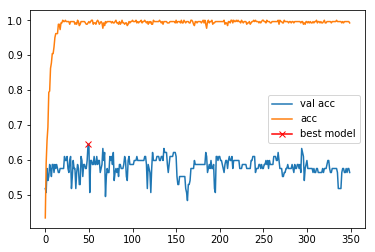

In [31]:
plt.plot(hist.history['val_acc'], label="val acc")
plt.plot(hist.history['acc'], label="acc")
plt.plot( np.argmax(hist.history["val_acc"]), np.max(hist.history["val_acc"]), 
         marker="x", color="r", label="best model")
plt.legend()
plt.show()

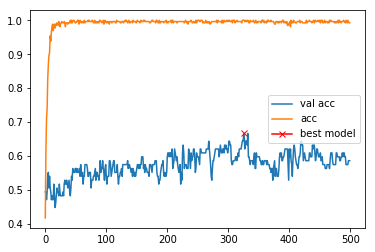

In [32]:
plt.plot(hist2.history['val_acc'], label="val acc")
plt.plot(hist2.history['acc'], label="acc")
plt.plot( np.argmax(hist2.history["val_acc"]), np.max(hist2.history["val_acc"]), 
         marker="x", color="r", label="best model")
plt.legend()
plt.show()

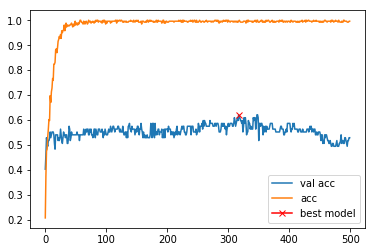

In [33]:
plt.plot(hist3.history['val_acc'], label="val acc")
plt.plot(hist3.history['acc'], label="acc")
plt.plot( np.argmax(hist3.history["val_acc"]), np.max(hist3.history["val_acc"]), 
         marker="x", color="r", label="best model")
plt.legend()
plt.show()

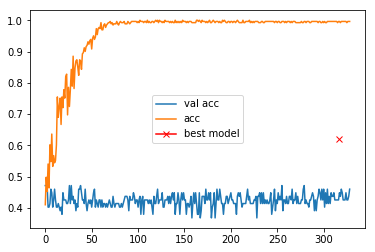

In [34]:
plt.plot(hist4.history['val_acc'], label="val acc")
plt.plot(hist4.history['acc'], label="acc")
plt.plot( np.argmax(hist3.history["val_acc"]), np.max(hist3.history["val_acc"]), 
         marker="x", color="r", label="best model")
plt.legend()
plt.show()

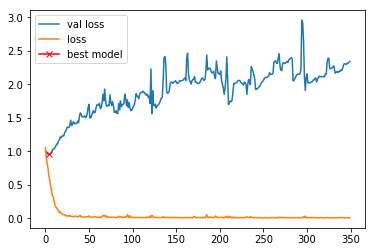

In [35]:
plt.plot(hist.history['val_loss'], label="val loss")
plt.plot(hist.history['loss'], label="loss")
plt.plot( np.argmin(hist.history["val_loss"]), np.min(hist.history["val_loss"]), 
         marker="x", color="r", label="best model")
plt.legend()
plt.show()

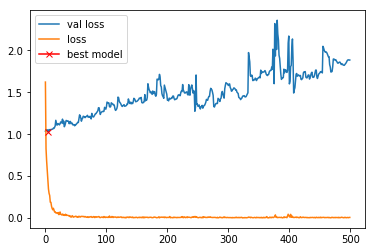

In [36]:
plt.plot(hist2.history['val_loss'], label="val loss")
plt.plot(hist2.history['loss'], label="loss")
plt.plot( np.argmin(hist2.history["val_loss"]), np.min(hist2.history["val_loss"]), 
         marker="x", color="r", label="best model")
plt.legend()
plt.show()

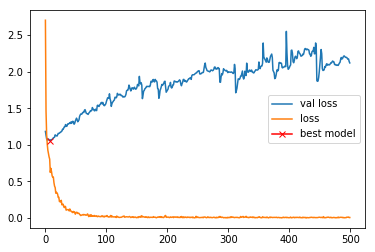

In [37]:
plt.plot(hist3.history['val_loss'], label="val loss")
plt.plot(hist3.history['loss'], label="loss")
plt.plot( np.argmin(hist3.history["val_loss"]), np.min(hist3.history["val_loss"]), 
         marker="x", color="r", label="best model")
plt.legend()
plt.show()

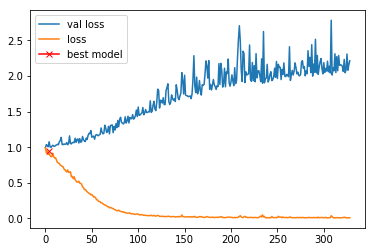

In [38]:
plt.plot(hist4.history['val_loss'], label="val loss")
plt.plot(hist4.history['loss'], label="loss")
plt.plot( np.argmin(hist.history["val_loss"]), np.min(hist.history["val_loss"]), 
         marker="x", color="r", label="best model")
plt.legend()
plt.show()

In [39]:
set_context("talk")

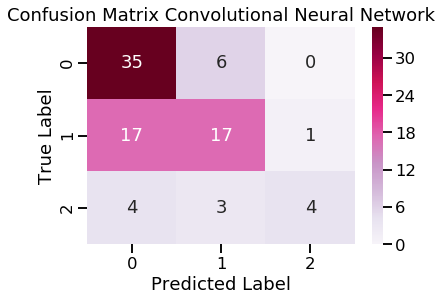

In [40]:
y_pred = model.predict_classes(x_val)
cm = confusion_matrix(np.argmax(y_val,axis=1),y_pred)

ax = plt.axes()
sns.heatmap(cm, annot=True, fmt="d", cmap="PuRd") #-___-
ax.set_title('Confusion Matrix Convolutional Neural Network')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
plt.show()

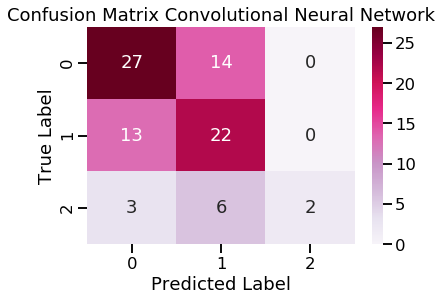

In [41]:
y_pred = model2.predict_classes(x_val)
cm = confusion_matrix(np.argmax(y_val,axis=1),y_pred)

ax = plt.axes()
sns.heatmap(cm, annot=True, fmt="d", cmap="PuRd") #-___-
ax.set_title('Confusion Matrix Convolutional Neural Network')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
plt.show()

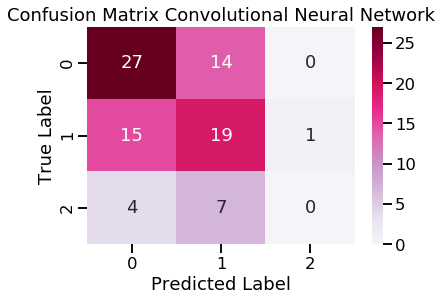

In [42]:
y_pred = model3.predict_classes(x_val)
cm = confusion_matrix(np.argmax(y_val,axis=1),y_pred)

ax = plt.axes()
sns.heatmap(cm, annot=True, fmt="d", cmap="PuRd") #-___-
ax.set_title('Confusion Matrix Convolutional Neural Network')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
plt.show()

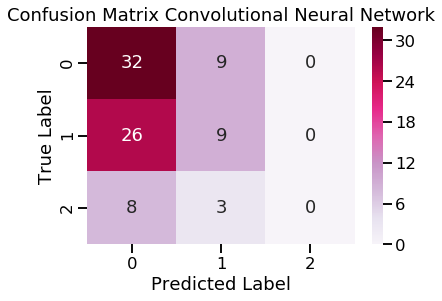

In [43]:
y_pred = model4.predict_classes(x_val)
cm = confusion_matrix(np.argmax(y_val,axis=1),y_pred)

ax = plt.axes()
sns.heatmap(cm, annot=True, fmt="d", cmap="PuRd") #-___-
ax.set_title('Confusion Matrix Convolutional Neural Network')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
plt.show()

In [50]:
y_pred_test = model.predict_classes(x_test)

rdf = pd.DataFrame(columns=['id','kelas'])
rdf['id'] = ids.copy()
rdf['kelas'] = y_pred_test.copy()
rdf.to_csv("results.csv",index=False)

In [51]:
from IPython.display import HTML
import base64

def create_download_link(rdf, title = "Download CSV file", filename = "XceptionNonFlip.csv"):  
    csv = rdf.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe
create_download_link(rdf)